In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.stats import skew
import openpyxl
from sklearn.preprocessing import LabelEncoder
import numpy as np
from scipy import stats
import matplotlib.dates as mdates
import os

# 1. Cargar datos

In [49]:
bd = pd.read_excel(r"C:\Users\leand\OneDrive - PhD in Engineering\3. Doctoral proposal\Propuesta_V5_22_10_2025\Data_Ndvi.xlsx")

In [50]:
bd.head()

,Fecha,NDVI,NDVI_imputed,NDVI_prior_feat,NDVI_pred_model,NDVI_final,NDVI_fuente,Precipitaciones (mm),rain_sum_7,rain_sum_7_log1p,...,GDD_sum_14,GDD_sum_30,Humedad_(%),hum_ma_7,hum_ma_14,hum_lag1,doy_sin,doy_cos,NDVI_missing,days_since_last_NDVI
0,2009-03-21,NaN,NaN,0.642129,NaN,0.642129,prior_blend,5.4,5.4,1.856298,...,8.0,8.0,89.5,89.500000,89.500000,NaN,0.980575,0.196143,1,5.902633
1,2009-03-22,NaN,NaN,0.490953,NaN,0.490953,prior_blend,16.5,21.9,3.131137,...,16.0,16.0,97.0,93.250000,93.250000,89.5,0.983798,0.179281,1,5.902633
2,2009-03-23,NaN,NaN,0.465812,NaN,0.465812,prior_blend,11.8,33.7,3.546740,...,24.5,24.5,98.0,94.833333,94.833333,97.0,0.986731,0.162366,1,5.902633
3,2009-03-24,NaN,NaN,0.390806,NaN,0.390806,prior_blend,20.5,54.2,4.010963,...,33.0,33.0,94.5,94.750000,94.750000,98.0,0.989372,0.145404,1,5.902633
4,2009-03-25,NaN,NaN,0.339206,NaN,0.339206,prior_blend,17.8,72.0,4.290459,...,41.0,41.0,94.0,94.600000,94.600000,94.5,0.991723,0.128398,1,5.902633


# 2. Seleccionar variables (NDVI, Precipitaciones (mm), Máx_grado_C, Mín_grado_C, Humedad_(%))

In [51]:
feature = [0, 1, 7, 18, 19, 27]
XDB = bd.iloc[:, feature].copy()

In [52]:
XDB.head()

,Fecha,NDVI,Precipitaciones (mm),Máx_grado_C,Mín_grado_C,Humedad_(%)
0,2009-03-21,NaN,5.4,21,15,89.5
1,2009-03-22,NaN,16.5,21,15,97.0
2,2009-03-23,NaN,11.8,21,16,98.0
3,2009-03-24,NaN,20.5,22,15,94.5
4,2009-03-25,NaN,17.8,21,15,94.0



# 3. Carga y Limpieza de la Serie Temporal: Objetivo: Importar datos, filtrar el rango de fechas (2009-2017) y eliminar valores nulos.

In [53]:
XDB['Fecha'] = pd.to_datetime(XDB['Fecha'], errors='coerce')
start, end = pd.to_datetime(['2009-03-21', '2017-01-26'])
lo, hi = min(start, end), max(start, end)

mask = XDB['Fecha'].between(lo, hi, inclusive='both')  
before = len(XDB)
XDB = XDB.loc[~mask].copy()
print(f"Filas eliminadas en el rango: {before - len(XDB)}")

Filas eliminadas en el rango: 2869


In [54]:
XDB

,Fecha,NDVI,Precipitaciones (mm),Máx_grado_C,Mín_grado_C,Humedad_(%)
2869,2017-01-27,0.44,0.0,25,11,78.5
2870,2017-01-28,NaN,5.5,25,12,80.0
2871,2017-01-29,NaN,6.2,22,12,79.5
2872,2017-01-30,NaN,9.1,21,12,82.5
2873,2017-01-31,NaN,8.9,22,11,80.0
...,...,...,...,...,...,...
5839,2025-03-16,NaN,18.4,23,13,85.0
5840,2025-03-17,NaN,24.9,23,13,84.0
5841,2025-03-18,NaN,26.7,21,15,87.0
5842,2025-03-19,NaN,6.1,25,15,79.0


# 4. Solo utilizar registros con presencia de NDVI (121 registros)

In [55]:
feature1 = [1]
XDB1 = bd.iloc[:, feature1].copy()

In [56]:
XDB1 = XDB1.dropna()

In [57]:
XDB2 = XDB1.values

In [58]:
XDB2.shape

(121, 1)

# 5. Distribuciones Estadísticas para Modelar las Variables Climáticas

In [59]:
distros = {
    "normal": stats.norm,
    "gamma": stats.gamma,
    "lognormal": stats.lognorm
}

# 6. Estimación de Parámetros y Selección de Modelos por Criterios de Información (AIC/BIC) NDVI

In [60]:
resultados = []
n = len(XDB2)

for nombre, dist in distros.items():
    # Ajuste por máxima verosimilitud
    params = dist.fit(XDB2)

    # Log-verosimilitud
    logpdf_vals = dist.logpdf(XDB2, *params)
    logL = np.sum(logpdf_vals)

    k = len(params)  # número de parámetros
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL

    resultados.append({
        "modelo": nombre,
        "params": params,
        "logL": logL,
        "AIC": AIC,
        "BIC": BIC
    })

# Ordenar por AIC/BIC
orden_AIC = sorted(resultados, key=lambda x: x["AIC"])
orden_BIC = sorted(resultados, key=lambda x: x["BIC"])

c:\Users\leand\py-leand\Lib\site-packages\scipy\stats\_continuous_distns.py:6921: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


# 7. Visualización de Resultados y Jerarquización de Modelos (Ranking AIC/BIC) para NDVI

In [61]:
# ==========================
# 1) Print general por modelo 
# ==========================
print("=== RESULTADOS POR MODELO NDVI ===")
for r in resultados:
    print(f"\nModelo: {r['modelo']}")
    print(f"  Parámetros: {r['params']}")
    print(f"  logL      : {r['logL']:.4f}")
    print(f"  AIC       : {r['AIC']:.4f}")
    print(f"  BIC       : {r['BIC']:.4f}")

# ====================================
# 2) Ordenados por AIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR AIC (mejor primero) ===")
for r in orden_AIC:
    print(f"Modelo: {r['modelo']:10s} | AIC: {r['AIC']:.4f} | BIC: {r['BIC']:.4f}")

# ====================================
# 3) Ordenados por BIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR BIC (mejor primero) ===")
for r in orden_BIC:
    print(f"Modelo: {r['modelo']:10s} | BIC: {r['BIC']:.4f} | AIC: {r['AIC']:.4f}")

# ====================================
# 4) Ganadores (best in class)
# ====================================
mejor_AIC = orden_AIC[0]
mejor_BIC = orden_BIC[0]

print("\n\n>>> MEJOR MODELO SEGÚN AIC:")
print(f"Modelo: {mejor_AIC['modelo']}")
print(f"AIC   : {mejor_AIC['AIC']:.4f}")
print(f"BIC   : {mejor_AIC['BIC']:.4f}")
print(f"Params: {mejor_AIC['params']}")

print("\n>>> MEJOR MODELO SEGÚN BIC:")
print(f"Modelo: {mejor_BIC['modelo']}")
print(f"BIC   : {mejor_BIC['BIC']:.4f}")
print(f"AIC   : {mejor_BIC['AIC']:.4f}")
print(f"Params: {mejor_BIC['params']}")

=== RESULTADOS POR MODELO NDVI ===

Modelo: normal
  Parámetros: (np.float64(0.5995867768595042), np.float64(0.17749122522468574))
  logL      : 37.4974
  AIC       : -70.9947
  BIC       : -65.4031

Modelo: gamma
  Parámetros: (np.float64(202.17516545379), np.float64(-2.070968015858691), np.float64(0.013221969767018914))
  logL      : 33.7076
  AIC       : -61.4151
  BIC       : -53.0278

Modelo: lognormal
  Parámetros: (np.float64(0.0014400033520333812), np.float64(-122.92644003116453), np.float64(123.52591345960082))
  logL      : 37.3879
  AIC       : -68.7758
  BIC       : -60.3884


=== MODELOS ORDENADOS POR AIC (mejor primero) ===
Modelo: normal     | AIC: -70.9947 | BIC: -65.4031
Modelo: lognormal  | AIC: -68.7758 | BIC: -60.3884
Modelo: gamma      | AIC: -61.4151 | BIC: -53.0278


=== MODELOS ORDENADOS POR BIC (mejor primero) ===
Modelo: normal     | BIC: -65.4031 | AIC: -70.9947
Modelo: lognormal  | BIC: -60.3884 | AIC: -68.7758
Modelo: gamma      | BIC: -53.0278 | AIC: -61.4

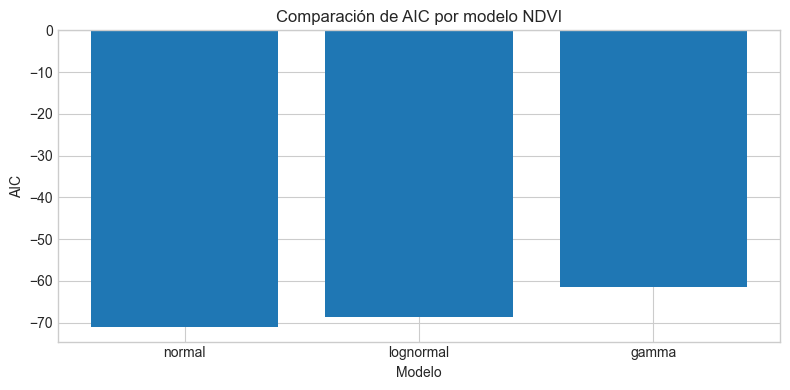

In [62]:
# --- AIC ordenado ---
modelos_aic = [r["modelo"] for r in orden_AIC]
aics = [r["AIC"] for r in orden_AIC]

x = np.arange(len(modelos_aic))

plt.figure(figsize=(8, 4))
plt.bar(x, aics)
plt.xticks(x, modelos_aic)
plt.xlabel("Modelo")
plt.ylabel("AIC")
plt.title("Comparación de AIC por modelo NDVI")
plt.tight_layout()
plt.show()

Para el NDVI, seleccionas la Distribución Normal porque presenta el AIC mínimo (el valor más negativo), lo que indica que pierde menos información que los otros modelos al representar los datos.

# 8. Evaluación de Distribuciones Continuas sobre la Serie Total de Precipitación (Incluyendo Ceros)


In [63]:
feature1 = [7]
XDB3 = bd.iloc[:, feature1].copy()

In [64]:
XDB4 = XDB3.values

In [65]:
XDB4

array([[ 5.4],
       [16.5],
       [11.8],
       ...,
       [26.7],
       [ 6.1],
       [14.7]], shape=(5844, 1))

# 9. Estimación de Parámetros y Selección del Modelo para la Precipitación (AIC/BIC) Precipitación (Incluyendo Ceros)

In [66]:
resultados = []
n = len(XDB4)

for nombre, dist in distros.items():
    # Ajuste por máxima verosimilitud
    params = dist.fit(XDB4)

    # Log-verosimilitud
    logpdf_vals = dist.logpdf(XDB4, *params)
    logL = np.sum(logpdf_vals)

    k = len(params)  # número de parámetros
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL

    resultados.append({
        "modelo": nombre,
        "params": params,
        "logL": logL,
        "AIC": AIC,
        "BIC": BIC
    })

# Ordenar por AIC/BIC
orden_AIC = sorted(resultados, key=lambda x: x["AIC"])
orden_BIC = sorted(resultados, key=lambda x: x["BIC"])

c:\Users\leand\py-leand\Lib\site-packages\scipy\stats\_continuous_distns.py:6930: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
c:\Users\leand\py-leand\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [67]:
# ==========================
# 1) Print general por modelo
# ==========================
print("=== RESULTADOS POR MODELO PRECIPITACIÓN INCLUYENDO DIAS SIN LLUVIA (0) ===")
for r in resultados:
    print(f"\nModelo: {r['modelo']}")
    print(f"  Parámetros: {r['params']}")
    print(f"  logL      : {r['logL']:.4f}")
    print(f"  AIC       : {r['AIC']:.4f}")
    print(f"  BIC       : {r['BIC']:.4f}")

# ====================================
# 2) Ordenados por AIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR AIC (mejor primero) ===")
for r in orden_AIC:
    print(f"Modelo: {r['modelo']:10s} | AIC: {r['AIC']:.4f} | BIC: {r['BIC']:.4f}")

# ====================================
# 3) Ordenados por BIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR BIC (mejor primero) ===")
for r in orden_BIC:
    print(f"Modelo: {r['modelo']:10s} | BIC: {r['BIC']:.4f} | AIC: {r['AIC']:.4f}")

# ====================================
# 4) Ganadores (best in class)
# ====================================
mejor_AIC = orden_AIC[0]
mejor_BIC = orden_BIC[0]

print("\n\n>>> MEJOR MODELO SEGÚN AIC:")
print(f"Modelo: {mejor_AIC['modelo']}")
print(f"AIC   : {mejor_AIC['AIC']:.4f}")
print(f"BIC   : {mejor_AIC['BIC']:.4f}")
print(f"Params: {mejor_AIC['params']}")

print("\n>>> MEJOR MODELO SEGÚN BIC:")
print(f"Modelo: {mejor_BIC['modelo']}")
print(f"BIC   : {mejor_BIC['BIC']:.4f}")
print(f"AIC   : {mejor_BIC['AIC']:.4f}")
print(f"Params: {mejor_BIC['params']}")

=== RESULTADOS POR MODELO PRECIPITACIÓN INCLUYENDO DIAS SIN LLUVIA (0) ===

Modelo: normal
  Parámetros: (np.float64(8.561999657768652), np.float64(8.172973737627444))
  logL      : -20569.5438
  AIC       : 41143.0876
  BIC       : 41156.4340

Modelo: gamma
  Parámetros: (np.float64(0.86632970401064), np.float64(-7.463293704269434e-28), np.float64(7.76090370463654))
  logL      : -15246.0670
  AIC       : 30498.1339
  BIC       : 30518.1534

Modelo: lognormal
  Parámetros: (np.float64(188.847909453213), np.float64(-5e-324), np.float64(2.8091729163399946e-22))
  logL      : 251082.2088
  AIC       : -502158.4175
  BIC       : -502138.3980


=== MODELOS ORDENADOS POR AIC (mejor primero) ===
Modelo: lognormal  | AIC: -502158.4175 | BIC: -502138.3980
Modelo: gamma      | AIC: 30498.1339 | BIC: 30518.1534
Modelo: normal     | AIC: 41143.0876 | BIC: 41156.4340


=== MODELOS ORDENADOS POR BIC (mejor primero) ===
Modelo: lognormal  | BIC: -502138.3980 | AIC: -502158.4175
Modelo: gamma      | 

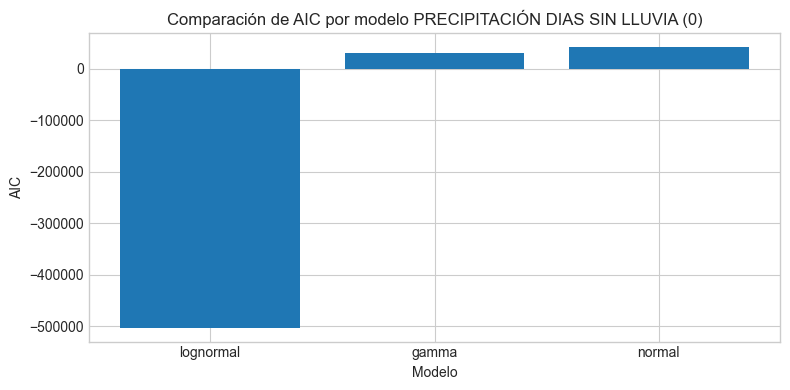

In [68]:
# --- AIC ordenado ---
modelos_aic = [r["modelo"] for r in orden_AIC]
aics = [r["AIC"] for r in orden_AIC]

x = np.arange(len(modelos_aic))

plt.figure(figsize=(8, 4))
plt.bar(x, aics)
plt.xticks(x, modelos_aic)
plt.xlabel("Modelo")
plt.ylabel("AIC")
plt.title("Comparación de AIC por modelo PRECIPITACIÓN DIAS SIN LLUVIA (0)")
plt.tight_layout()
plt.show()

Se destaca una anomalía crítica en el modelo **Lognormal**, el cual presenta un AIC extremadamente negativo ($\approx -500,000$). Este valor no debe interpretarse como un ajuste perfecto, sino como una **falla en la estimación de máxima verosimilitud**. La presencia de ceros en los datos provoca que el término $\ln(x)$ en la función de log-verosimilitud tienda a $-\infty$. Esto confirma que las distribuciones de soporte estrictamente positivo ($x > 0$), como la Gamma y Lognormal, son teóricamente incompatibles con la serie climática bruta sin un tratamiento previo de los ceros.

# 10. Modelado Estadístico de la Precipitación Positiva ($P_t > 0$)

In [69]:
import numpy as np

# 1. Filtrar solo precipitación positiva (> 0)
#    XDB4 puede ser un array de NumPy o una Serie de pandas
XDB4_pos = np.asarray(XDB4, dtype=float).ravel()
XDB4_pos = XDB4_pos[~np.isnan(XDB4_pos) & (XDB4_pos > 0)]

print("Número de observaciones con lluvia > 0:", len(XDB4_pos))

# 2. Calcular AIC/BIC sobre esos datos
resultados = []
n = len(XDB4_pos)

for nombre, dist in distros.items():
    # Opcional (muy recomendable para precipitación): fijar loc=0
    # en distribuciones que solo tienen soporte en [0, ∞)
    if nombre in ["gamma", "lognormal"]:
        params = dist.fit(XDB4_pos, floc=0)
    else:
        params = dist.fit(XDB4_pos)

    # Log-verosimilitud
    logpdf_vals = dist.logpdf(XDB4_pos, *params)
    logL = np.sum(logpdf_vals)

    k = len(params)  # número de parámetros
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL

    resultados.append({
        "modelo": nombre,
        "params": params,
        "logL": logL,
        "AIC": AIC,
        "BIC": BIC
    })

# 3. Ordenar por AIC/BIC
orden_AIC = sorted(resultados, key=lambda x: x["AIC"])
orden_BIC = sorted(resultados, key=lambda x: x["BIC"])


Número de observaciones con lluvia > 0: 5442


# 11. Visualización de Resultados y Jerarquización de Modelos (Ranking AIC/BIC) para PRECIPITACIÓN($P_t > 0$)

In [70]:
# ==========================
# 1) Print general por modelo
# ==========================
print("=== RESULTADOS POR MODELO PRECIPITACIÓN > 0 ===")
for r in resultados:
    print(f"\nModelo: {r['modelo']}")
    print(f"  Parámetros: {r['params']}")
    print(f"  logL      : {r['logL']:.4f}")
    print(f"  AIC       : {r['AIC']:.4f}")
    print(f"  BIC       : {r['BIC']:.4f}")

# ====================================
# 2) Ordenados por AIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR AIC (mejor primero) ===")
for r in orden_AIC:
    print(f"Modelo: {r['modelo']:10s} | AIC: {r['AIC']:.4f} | BIC: {r['BIC']:.4f}")

# ====================================
# 3) Ordenados por BIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR BIC (mejor primero) ===")
for r in orden_BIC:
    print(f"Modelo: {r['modelo']:10s} | BIC: {r['BIC']:.4f} | AIC: {r['AIC']:.4f}")

# ====================================
# 4) Ganadores (best in class)
# ====================================
mejor_AIC = orden_AIC[0]
mejor_BIC = orden_BIC[0]

print("\n\n>>> MEJOR MODELO SEGÚN AIC:")
print(f"Modelo: {mejor_AIC['modelo']}")
print(f"AIC   : {mejor_AIC['AIC']:.4f}")
print(f"BIC   : {mejor_AIC['BIC']:.4f}")
print(f"Params: {mejor_AIC['params']}")

print("\n>>> MEJOR MODELO SEGÚN BIC:")
print(f"Modelo: {mejor_BIC['modelo']}")
print(f"BIC   : {mejor_BIC['BIC']:.4f}")
print(f"AIC   : {mejor_BIC['AIC']:.4f}")
print(f"Params: {mejor_BIC['params']}")

=== RESULTADOS POR MODELO PRECIPITACIÓN > 0 ===

Modelo: normal
  Parámetros: (np.float64(9.194473722895996), np.float64(8.118901293866129))
  logL      : -19118.4718
  AIC       : 38240.9436
  BIC       : 38254.1474

Modelo: gamma
  Parámetros: (1.1047457873323234, 0, np.float64(8.322705393698111))
  logL      : -17498.9796
  AIC       : 35003.9592
  BIC       : 35023.7649

Modelo: lognormal
  Parámetros: (np.float64(1.2284637435069343), 0, np.float64(5.484981274439755))
  logL      : -18103.9918
  AIC       : 36213.9836
  BIC       : 36233.7893


=== MODELOS ORDENADOS POR AIC (mejor primero) ===
Modelo: gamma      | AIC: 35003.9592 | BIC: 35023.7649
Modelo: lognormal  | AIC: 36213.9836 | BIC: 36233.7893
Modelo: normal     | AIC: 38240.9436 | BIC: 38254.1474


=== MODELOS ORDENADOS POR BIC (mejor primero) ===
Modelo: gamma      | BIC: 35023.7649 | AIC: 35003.9592
Modelo: lognormal  | BIC: 36233.7893 | AIC: 36213.9836
Modelo: normal     | BIC: 38254.1474 | AIC: 38240.9436


>>> MEJOR M

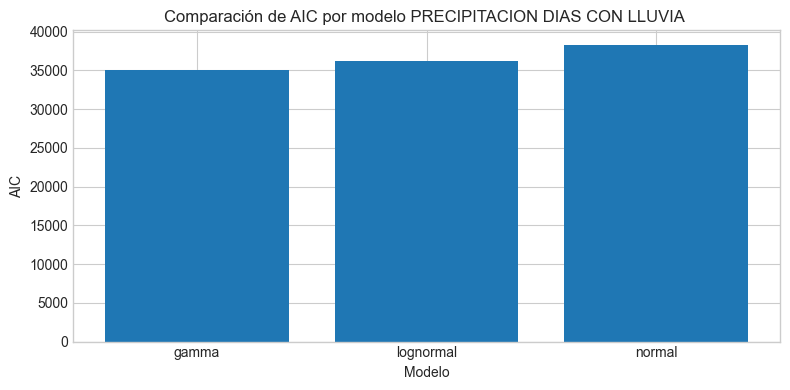

In [71]:
# --- AIC ordenado ---
modelos_aic = [r["modelo"] for r in orden_AIC]
aics = [r["AIC"] for r in orden_AIC]

x = np.arange(len(modelos_aic))

plt.figure(figsize=(8, 4))
plt.bar(x, aics)
plt.xticks(x, modelos_aic)
plt.xlabel("Modelo")
plt.ylabel("AIC")
plt.title("Comparación de AIC por modelo PRECIPITACION DIAS CON LLUVIA ")
plt.tight_layout()
plt.show()

In [72]:
XDB4

array([[ 5.4],
       [16.5],
       [11.8],
       ...,
       [26.7],
       [ 6.1],
       [14.7]], shape=(5844, 1))

=== AJUSTE MODELO BERNOULLI + GAMMA ===
Días totales (sin NaN)      : 5844
Días con lluvia > 0         : 5442
Días secos (lluvia = 0)     : 402
Probabilidad de lluvia p̂    : 0.9312

>>> Componente Gamma (lluvia | lluvia > 0)
shape (k)    : 1.1047
loc          : 0.0000
scale (θ)    : 8.3227
Media k·θ    : 9.1945
Varianza k·θ²: 76.5229


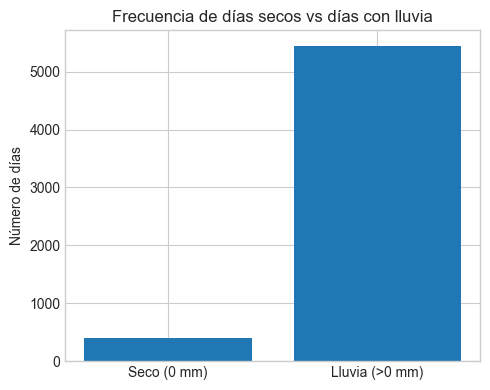

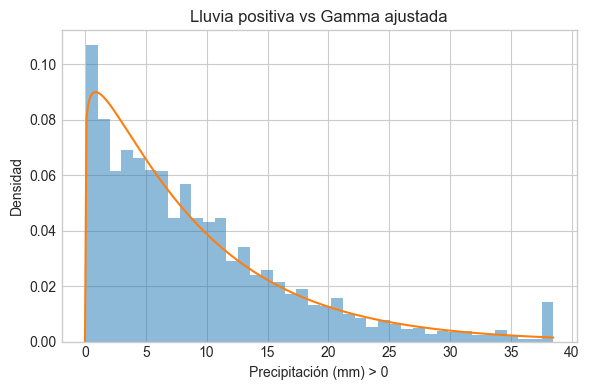

{'p_lluvia': np.float64(0.9312114989733059), 'gamma_params': (1.1047457873323234, 0, np.float64(8.322705393698111)), 'n_total': 5844, 'n_lluvia_pos': np.int64(5442), 'media_gamma': np.float64(9.194473722895994), 'var_gamma': np.float64(76.52289604576205)}


In [73]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

lluvia = XDB4.ravel()

def ajustar_bernoulli_gamma(lluvia, verbose=True, plot=True, bins=40):
    """
    lluvia: array-like con precipitación diaria (puede tener ceros y NaN)
    return: dict con:
        - p_lluvia      : probabilidad estimada de lluvia (>0)
        - gamma_params  : (shape, loc, scale) de la Gamma condicional
        - n_total       : número total de días (sin NaN)
        - n_lluvia_pos  : número de días con lluvia > 0
        - media_gamma   : media teórica de la Gamma
        - var_gamma     : varianza teórica de la Gamma
    """
    lluvia = np.asarray(lluvia, dtype=float)
    lluvia = lluvia[~np.isnan(lluvia)]  # quitamos NaN
    
    # Componente Bernoulli: probabilidad de que llueva (>0)
    positivos = lluvia > 0
    p_lluvia = positivos.mean()          # P(lluvia > 0)
    
    n_total = len(lluvia)
    n_lluvia_pos = positivos.sum()
    n_secos = n_total - n_lluvia_pos
    
    # Componente Gamma: solo sobre lluvia positiva
    lluvia_pos = lluvia[positivos]
    
    # Ajuste Gamma con soporte [0, ∞): fijamos loc=0
    shape, loc, scale = stats.gamma.fit(lluvia_pos, floc=0)
    
    # Media y varianza teórica de la Gamma
    media_gamma = shape * scale
    var_gamma = shape * (scale ** 2)
    
    if verbose:
        print("=== AJUSTE MODELO BERNOULLI + GAMMA ===")
        print(f"Días totales (sin NaN)      : {n_total}")
        print(f"Días con lluvia > 0         : {n_lluvia_pos}")
        print(f"Días secos (lluvia = 0)     : {n_secos}")
        print(f"Probabilidad de lluvia p̂    : {p_lluvia:.4f}")
        print()
        print(">>> Componente Gamma (lluvia | lluvia > 0)")
        print(f"shape (k)    : {shape:.4f}")
        print(f"loc          : {loc:.4f}")
        print(f"scale (θ)    : {scale:.4f}")
        print(f"Media k·θ    : {media_gamma:.4f}")
        print(f"Varianza k·θ²: {var_gamma:.4f}")
        print("=========================================")
    
    if plot:
        # ==============================
        # 1) Gráfico de días secos vs lluviosos
        # ==============================
        plt.figure(figsize=(5, 4))
        etiquetas = ["Seco (0 mm)", "Lluvia (>0 mm)"]
        valores = [n_secos, n_lluvia_pos]
        posiciones = np.arange(len(etiquetas))
        
        plt.bar(posiciones, valores)
        plt.xticks(posiciones, etiquetas)
        plt.ylabel("Número de días")
        plt.title("Frecuencia de días secos vs días con lluvia")
        plt.tight_layout()
        plt.show()
        
        # ==============================
        # 2) Histograma lluvia > 0 + densidad Gamma ajustada
        # ==============================
        plt.figure(figsize=(6, 4))
        
        # Histograma normalizado (densidad)
        plt.hist(lluvia_pos, bins=bins, density=True, alpha=0.5)
        
        # Soporte para la curva teórica de la Gamma
        x_min = 0
        x_max = np.percentile(lluvia_pos, 99)  # evitar colas extremas
        x = np.linspace(x_min, x_max, 300)
        
        pdf_gamma = stats.gamma.pdf(x, shape, loc=loc, scale=scale)
        plt.plot(x, pdf_gamma)
        
        plt.xlabel("Precipitación (mm) > 0")
        plt.ylabel("Densidad")
        plt.title("Lluvia positiva vs Gamma ajustada")
        plt.tight_layout()
        plt.show()
    
    return {
        "p_lluvia": p_lluvia,
        "gamma_params": (shape, loc, scale),
        "n_total": n_total,
        "n_lluvia_pos": n_lluvia_pos,
        "media_gamma": media_gamma,
        "var_gamma": var_gamma
    }

# Ejemplo de uso con tu columna de precipitación:
params = ajustar_bernoulli_gamma(XDB4)
print(params)


# 13. Estimación de Parámetros y Selección del Modelo para la Precipitación (AIC/BIC) Temperatura Mínima


In [74]:
feature1 = [19]
XDB5 = bd.iloc[:, feature1].copy()

In [75]:
XDB5

,Mín_grado_C
0,15
1,15
2,16
3,15
4,15
...,...
5839,13
5840,13
5841,15
5842,15


In [76]:
resultados = []
n = len(XDB5)

for nombre, dist in distros.items():
    # Ajuste por máxima verosimilitud
    params = dist.fit(XDB5)

    # Log-verosimilitud
    logpdf_vals = dist.logpdf(XDB5, *params)
    logL = np.sum(logpdf_vals)

    k = len(params)  # número de parámetros
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL

    resultados.append({
        "modelo": nombre,
        "params": params,
        "logL": logL,
        "AIC": AIC,
        "BIC": BIC
    })

# Ordenar por AIC/BIC
orden_AIC = sorted(resultados, key=lambda x: x["AIC"])
orden_BIC = sorted(resultados, key=lambda x: x["BIC"])

# 14. Visualización de Resultados y Jerarquización de Modelos (Ranking AIC/BIC) para TEMPERATURA MÍNIMA

In [77]:
# ==========================
# 1) Print general por modelo
# ==========================
print("=== RESULTADOS POR MODELO TEMPERATURA MÍNIMA ===")
for r in resultados:
    print(f"\nModelo: {r['modelo']}")
    print(f"  Parámetros: {r['params']}")
    print(f"  logL      : {r['logL']:.4f}")
    print(f"  AIC       : {r['AIC']:.4f}")
    print(f"  BIC       : {r['BIC']:.4f}")

# ====================================
# 2) Ordenados por AIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR AIC (mejor primero) ===")
for r in orden_AIC:
    print(f"Modelo: {r['modelo']:10s} | AIC: {r['AIC']:.4f} | BIC: {r['BIC']:.4f}")

# ====================================
# 3) Ordenados por BIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR BIC (mejor primero) ===")
for r in orden_BIC:
    print(f"Modelo: {r['modelo']:10s} | BIC: {r['BIC']:.4f} | AIC: {r['AIC']:.4f}")

# ====================================
# 4) Ganadores (best in class)
# ====================================
mejor_AIC = orden_AIC[0]
mejor_BIC = orden_BIC[0]

print("\n\n>>> MEJOR MODELO SEGÚN AIC:")
print(f"Modelo: {mejor_AIC['modelo']}")
print(f"AIC   : {mejor_AIC['AIC']:.4f}")
print(f"BIC   : {mejor_AIC['BIC']:.4f}")
print(f"Params: {mejor_AIC['params']}")

print("\n>>> MEJOR MODELO SEGÚN BIC:")
print(f"Modelo: {mejor_BIC['modelo']}")
print(f"BIC   : {mejor_BIC['BIC']:.4f}")
print(f"AIC   : {mejor_BIC['AIC']:.4f}")
print(f"Params: {mejor_BIC['params']}")

=== RESULTADOS POR MODELO TEMPERATURA MÍNIMA ===

Modelo: normal
  Parámetros: (np.float64(12.82819986310746), np.float64(1.1359890068613205))
  logL      : -9037.4081
  AIC       : 18078.8162
  BIC       : 18092.1625

Modelo: gamma
  Parámetros: (np.float64(209.85034011581246), np.float64(-3.626261033782149), np.float64(0.07841045592714703))
  logL      : -9027.5051
  AIC       : 18061.0101
  BIC       : 18081.0297

Modelo: lognormal
  Parámetros: (np.float64(0.04659292860936244), -11.537637776289735, np.float64(24.33940313049448))
  logL      : -9027.3940
  AIC       : 18060.7879
  BIC       : 18080.8074


=== MODELOS ORDENADOS POR AIC (mejor primero) ===
Modelo: lognormal  | AIC: 18060.7879 | BIC: 18080.8074
Modelo: gamma      | AIC: 18061.0101 | BIC: 18081.0297
Modelo: normal     | AIC: 18078.8162 | BIC: 18092.1625


=== MODELOS ORDENADOS POR BIC (mejor primero) ===
Modelo: lognormal  | BIC: 18080.8074 | AIC: 18060.7879
Modelo: gamma      | BIC: 18081.0297 | AIC: 18061.0101
Modelo:

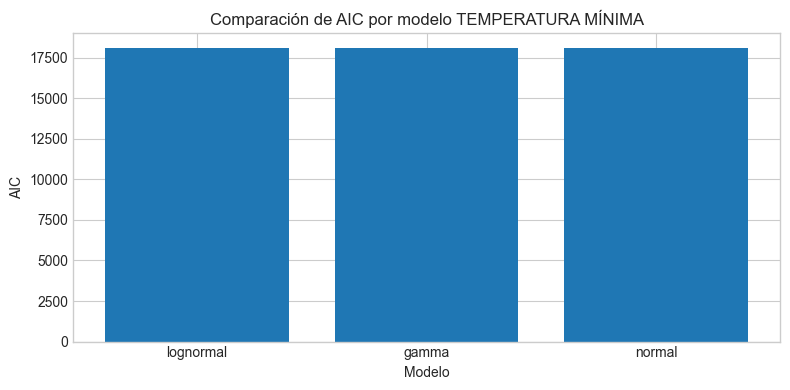

In [78]:
# --- AIC ordenado ---
modelos_aic = [r["modelo"] for r in orden_AIC]
aics = [r["AIC"] for r in orden_AIC]

x = np.arange(len(modelos_aic))

plt.figure(figsize=(8, 4))
plt.bar(x, aics)
plt.xticks(x, modelos_aic)
plt.xlabel("Modelo")
plt.ylabel("AIC")
plt.title("Comparación de AIC por modelo TEMPERATURA MÍNIMA")
plt.tight_layout()
plt.show()

Se comparó la bondad de ajuste de las distribuciones Normal, Lognormal y Gamma utilizando el Criterio de Información de Akaike (AIC). Los resultados mostraron diferencias insignificantes entre los valores de AIC de los tres modelos candidatos. En consecuencia, se seleccionó la distribución Normal basándose en el principio de parsimonia y en su capacidad para modelar valores negativos, una característica inherente a los datos de temperatura mínima que las distribuciones Gamma y Lognormal no pueden manejar directamente sin parámetros de desplazamiento adicionales

# 15. Estimación de Parámetros y Selección del Modelo para la Precipitación (AIC/BIC) TEMPERATURA MÁXIMA

In [79]:
feature1 = [18]
XDB5 = bd.iloc[:, feature1].copy()

In [80]:
XDB5

,Máx_grado_C
0,21
1,21
2,21
3,22
4,21
...,...
5839,23
5840,23
5841,21
5842,25


In [81]:
resultados = []
n = len(XDB5)

for nombre, dist in distros.items():
    # Ajuste por máxima verosimilitud
    params = dist.fit(XDB5)

    # Log-verosimilitud
    logpdf_vals = dist.logpdf(XDB5, *params)
    logL = np.sum(logpdf_vals)

    k = len(params)  # número de parámetros
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL

    resultados.append({
        "modelo": nombre,
        "params": params,
        "logL": logL,
        "AIC": AIC,
        "BIC": BIC
    })

# Ordenar por AIC/BIC
orden_AIC = sorted(resultados, key=lambda x: x["AIC"])
orden_BIC = sorted(resultados, key=lambda x: x["BIC"])

# 16. Visualización de Resultados y Jerarquización de Modelos (Ranking AIC/BIC) para TEMPERATURA MÁXIMA

In [82]:
# ==========================
# 1) Print general por modelo
# ==========================
print("=== RESULTADOS POR MODELO ===")
for r in resultados:
    print(f"\nModelo: {r['modelo']}")
    print(f"  Parámetros: {r['params']}")
    print(f"  logL      : {r['logL']:.4f}")
    print(f"  AIC       : {r['AIC']:.4f}")
    print(f"  BIC       : {r['BIC']:.4f}")

# ====================================
# 2) Ordenados por AIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR AIC (mejor primero) ===")
for r in orden_AIC:
    print(f"Modelo: {r['modelo']:10s} | AIC: {r['AIC']:.4f} | BIC: {r['BIC']:.4f}")

# ====================================
# 3) Ordenados por BIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR BIC (mejor primero) ===")
for r in orden_BIC:
    print(f"Modelo: {r['modelo']:10s} | BIC: {r['BIC']:.4f} | AIC: {r['AIC']:.4f}")

# ====================================
# 4) Ganadores (best in class)
# ====================================
mejor_AIC = orden_AIC[0]
mejor_BIC = orden_BIC[0]

print("\n\n>>> MEJOR MODELO SEGÚN AIC:")
print(f"Modelo: {mejor_AIC['modelo']}")
print(f"AIC   : {mejor_AIC['AIC']:.4f}")
print(f"BIC   : {mejor_AIC['BIC']:.4f}")
print(f"Params: {mejor_AIC['params']}")

print("\n>>> MEJOR MODELO SEGÚN BIC:")
print(f"Modelo: {mejor_BIC['modelo']}")
print(f"BIC   : {mejor_BIC['BIC']:.4f}")
print(f"AIC   : {mejor_BIC['AIC']:.4f}")
print(f"Params: {mejor_BIC['params']}")

=== RESULTADOS POR MODELO ===

Modelo: normal
  Parámetros: (np.float64(23.53832991101985), np.float64(2.921878518344602))
  logL      : -14558.3698
  AIC       : 29120.7397
  BIC       : 29134.0860

Modelo: gamma
  Parámetros: (np.float64(2080.31834000181), np.float64(-109.88959122407846), np.float64(0.06413701013584247))
  logL      : -14560.8035
  AIC       : 29127.6069
  BIC       : 29147.6264

Modelo: lognormal
  Parámetros: (np.float64(1.6901539498250733e-05), -172853.0072139726, np.float64(172876.5455191915))
  logL      : -14558.3723
  AIC       : 29122.7447
  BIC       : 29142.7642


=== MODELOS ORDENADOS POR AIC (mejor primero) ===
Modelo: normal     | AIC: 29120.7397 | BIC: 29134.0860
Modelo: lognormal  | AIC: 29122.7447 | BIC: 29142.7642
Modelo: gamma      | AIC: 29127.6069 | BIC: 29147.6264


=== MODELOS ORDENADOS POR BIC (mejor primero) ===
Modelo: normal     | BIC: 29134.0860 | AIC: 29120.7397
Modelo: lognormal  | BIC: 29142.7642 | AIC: 29122.7447
Modelo: gamma      | BI

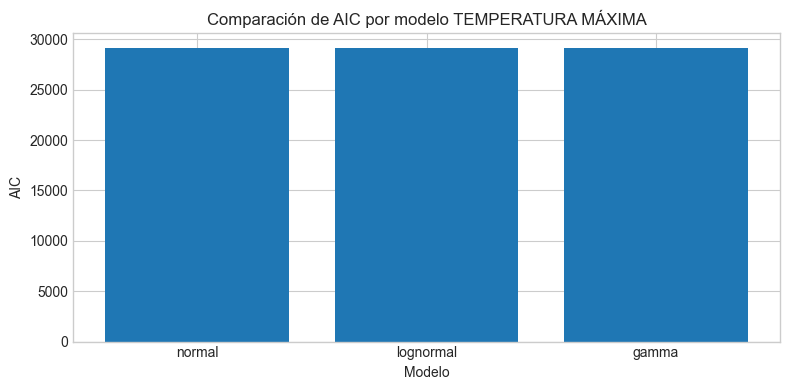

In [83]:
# --- AIC ordenado ---
modelos_aic = [r["modelo"] for r in orden_AIC]
aics = [r["AIC"] for r in orden_AIC]

x = np.arange(len(modelos_aic))

plt.figure(figsize=(8, 4))
plt.bar(x, aics)
plt.xticks(x, modelos_aic)
plt.xlabel("Modelo")
plt.ylabel("AIC")
plt.title("Comparación de AIC por modelo TEMPERATURA MÁXIMA")
plt.tight_layout()
plt.show()

Para la variable de Temperatura Máxima, el criterio AIC no mostró diferencias significativas entre las distribuciones candidatas. Por consistencia con la variable de Temperatura Mínima y para explotar la correlación entre ambas variables, se selecciona la distribución Normal. Esto permite modelar las emisiones del HMM mediante una Distribución Normal Bivariada, capturando no solo la varianza individual de cada temperatura, sino también su covarianza conjunta dentro de cada régimen climático

# 17. Estimación de Parámetros y Selección del Modelo para la Precipitación (AIC/BIC) HUMEDAD

In [84]:
feature1 = [27]
XDB6 = bd.iloc[:, feature1].copy()

In [85]:
XDB6

,Humedad_(%)
0,89.5
1,97.0
2,98.0
3,94.5
4,94.0
...,...
5839,85.0
5840,84.0
5841,87.0
5842,79.0


In [86]:
resultados = []
n = len(XDB6)

for nombre, dist in distros.items():
    # Ajuste por máxima verosimilitud
    params = dist.fit(XDB6)

    # Log-verosimilitud
    logpdf_vals = dist.logpdf(XDB6, *params)
    logL = np.sum(logpdf_vals)

    k = len(params)  # número de parámetros
    AIC = 2 * k - 2 * logL
    BIC = k * np.log(n) - 2 * logL

    resultados.append({
        "modelo": nombre,
        "params": params,
        "logL": logL,
        "AIC": AIC,
        "BIC": BIC
    })

# Ordenar por AIC/BIC
orden_AIC = sorted(resultados, key=lambda x: x["AIC"])
orden_BIC = sorted(resultados, key=lambda x: x["BIC"])

# 18. Visualización de Resultados y Jerarquización de Modelos (Ranking AIC/BIC) para HUMEDAD

In [87]:
# ==========================
# 1) Print general por modelo
# ==========================
print("=== RESULTADOS POR MODELO ===")
for r in resultados:
    print(f"\nModelo: {r['modelo']}")
    print(f"  Parámetros: {r['params']}")
    print(f"  logL      : {r['logL']:.4f}")
    print(f"  AIC       : {r['AIC']:.4f}")
    print(f"  BIC       : {r['BIC']:.4f}")

# ====================================
# 2) Ordenados por AIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR AIC (mejor primero) ===")
for r in orden_AIC:
    print(f"Modelo: {r['modelo']:10s} | AIC: {r['AIC']:.4f} | BIC: {r['BIC']:.4f}")

# ====================================
# 3) Ordenados por BIC (de menor a mayor)
# ====================================
print("\n\n=== MODELOS ORDENADOS POR BIC (mejor primero) ===")
for r in orden_BIC:
    print(f"Modelo: {r['modelo']:10s} | BIC: {r['BIC']:.4f} | AIC: {r['AIC']:.4f}")

# ====================================
# 4) Ganadores (best in class)
# ====================================
mejor_AIC = orden_AIC[0]
mejor_BIC = orden_BIC[0]

print("\n\n>>> MEJOR MODELO SEGÚN AIC:")
print(f"Modelo: {mejor_AIC['modelo']}")
print(f"AIC   : {mejor_AIC['AIC']:.4f}")
print(f"BIC   : {mejor_AIC['BIC']:.4f}")
print(f"Params: {mejor_AIC['params']}")

print("\n>>> MEJOR MODELO SEGÚN BIC:")
print(f"Modelo: {mejor_BIC['modelo']}")
print(f"BIC   : {mejor_BIC['BIC']:.4f}")
print(f"AIC   : {mejor_BIC['AIC']:.4f}")
print(f"Params: {mejor_BIC['params']}")

=== RESULTADOS POR MODELO ===

Modelo: normal
  Parámetros: (np.float64(78.93634496919918), np.float64(8.946828639146092))
  logL      : -21098.2289
  AIC       : 42200.4578
  BIC       : 42213.8041

Modelo: gamma
  Parámetros: (np.float64(431.0200646223725), np.float64(-107.40513665125184), np.float64(0.4323957623583887))
  logL      : -21119.3237
  AIC       : 42244.6474
  BIC       : 42264.6669

Modelo: lognormal
  Parámetros: (np.float64(1.7087433965938465e-05), -523513.0370238547, np.float64(523591.97329238435))
  logL      : -21098.2384
  AIC       : 42202.4769
  BIC       : 42222.4964


=== MODELOS ORDENADOS POR AIC (mejor primero) ===
Modelo: normal     | AIC: 42200.4578 | BIC: 42213.8041
Modelo: lognormal  | AIC: 42202.4769 | BIC: 42222.4964
Modelo: gamma      | AIC: 42244.6474 | BIC: 42264.6669


=== MODELOS ORDENADOS POR BIC (mejor primero) ===
Modelo: normal     | BIC: 42213.8041 | AIC: 42200.4578
Modelo: lognormal  | BIC: 42222.4964 | AIC: 42202.4769
Modelo: gamma      | B

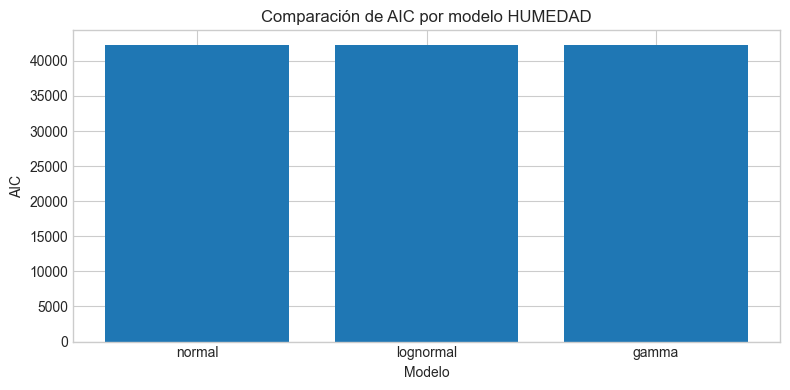

In [88]:
# --- AIC ordenado ---
modelos_aic = [r["modelo"] for r in orden_AIC]
aics = [r["AIC"] for r in orden_AIC]

x = np.arange(len(modelos_aic))

plt.figure(figsize=(8, 4))
plt.bar(x, aics)
plt.xticks(x, modelos_aic)
plt.xlabel("Modelo")
plt.ylabel("AIC")
plt.title("Comparación de AIC por modelo HUMEDAD")
plt.tight_layout()
plt.show()

El modelo Normal asume que los valores negativos son posibles (lo cual es incorrecto físicamente), mientras que el Lognormal respeta esta restricción física. Dado que tienen el mismo AIC, el Lognormal es el modelo más robusto y coherente para la variable humedad.

In [89]:
import pandas as pd

# 1. Asegúrate de que la columna Fecha sea de tipo datetime (si no lo es ya)
bd['Fecha'] = pd.to_datetime(bd['Fecha'])

# 2. DEFINIR LA FECHA DE CORTE
# Todo lo que sea MENOR a esta fecha se eliminará (se hace drop).
fecha_corte = '2017-01-26' 

# 3. APLICAR EL FILTRO Y CREAR LA COPIA
# "Quédate solo con las filas donde la Fecha sea mayor o igual a la fecha de corte"
bd_filtrada = bd.loc[bd['Fecha'] >= fecha_corte].copy()

# (Opcional) Si quieres sobreescribir la variable original:
# bd = bd.loc[bd['Fecha'] >= fecha_corte].copy()

# Verificación
print(f"Rango de fechas original: {bd['Fecha'].min()} a {bd['Fecha'].max()}")
print(f"Rango de fechas filtrado: {bd_filtrada['Fecha'].min()} a {bd_filtrada['Fecha'].max()}")

Rango de fechas original: 2009-03-21 00:00:00 a 2025-03-20 00:00:00
Rango de fechas filtrado: 2017-01-26 00:00:00 a 2025-03-20 00:00:00


# Análisis de Registros de NDVI Observado vs. Variables Agroclimáticas

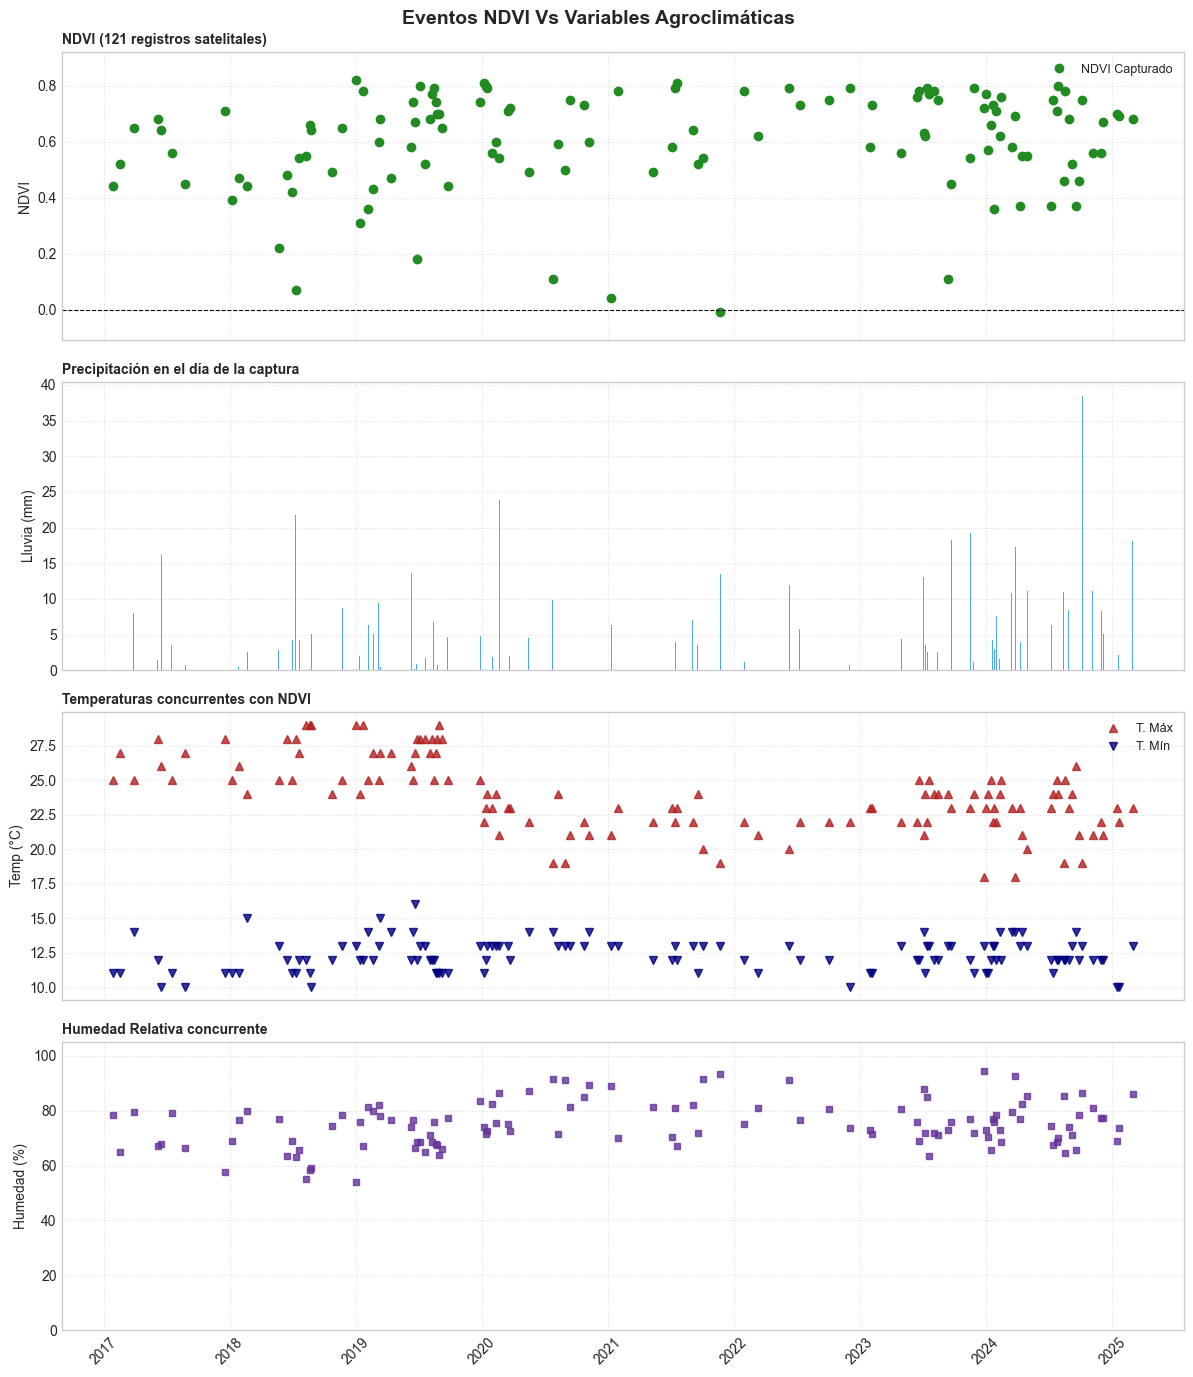

In [90]:
# -------------------------------------------------------------------------
# 1. CARGA Y FILTRADO DE DATOS (Solo Datos Reales)
# -------------------------------------------------------------------------

# Asumimos que 'bd_filtrada' ya existe en tu memoria.
# Si la cargas desde un archivo, usa: pd.read_csv(...)
try:
    df_original = pd.DataFrame(bd_filtrada)
except NameError:
    print("Error: No se encontró la variable 'bd_filtrada'. Carga tus datos primero.")
    # Para que el código no falle si lo pegas sin datos, creamos un df vacío de seguridad
    df_original = pd.DataFrame(columns=['Fecha', 'NDVI', 'Precipitaciones (mm)', 
                                      'Máx_grado_C', 'Mín_grado_C', 'Humedad_(%)'])

# Asegurar formato de fecha
if not df_original.empty:
    df_original['Fecha'] = pd.to_datetime(df_original['Fecha'])
    df_original = df_original.sort_values('Fecha')

# --- EL FILTRO CRÍTICO ---
# "Si no hay NDVI, no quiero ver el clima de ese día".
# Eliminamos cualquier fila donde NDVI sea NaN (vacío).
df_sincronizado = df_original.dropna(subset=['NDVI']).copy()

# -------------------------------------------------------------------------
# 2. GRAFICACIÓN ESTRICTA (Sin interpolar, Solo Puntos Concurrentes)
# -------------------------------------------------------------------------
def plot_agroclimatic_synced(df):
    if df.empty:
        print("Advertencia: No hay datos para graficar después de filtrar por NDVI.")
        return

    # Configuración de estilo
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 4 filas, compartiendo eje X
    fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    
    # --- GRÁFICO 1: NDVI (Puntos) ---
    ax1 = axes[0]
    # linestyle='None': NO une los puntos. Muestra el dato crudo aislado.
    ax1.plot(df['Fecha'], df['NDVI'], color='forestgreen', 
             marker='o', linestyle='None', markersize=6, label='NDVI Capturado')
    
    ax1.axhline(0, color='black', linewidth=0.8, linestyle='--') # Línea de referencia
    ax1.set_ylabel('NDVI')
    ax1.set_title(f'NDVI ({len(df)} registros satelitales)', loc='left', fontweight='bold', fontsize=10)
    ax1.legend(loc='upper right', fontsize=9)
    # Ajusta esto según tus datos reales (ej: -0.2 a 1.0)
    ax1.set_ylim(df['NDVI'].min() - 0.1, df['NDVI'].max() + 0.1) 
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- GRÁFICO 2: PRECIPITACIÓN (Barras) ---
    ax2 = axes[1]
    # Solo muestra barras en los días que hubo foto satelital
    ax2.bar(df['Fecha'], df['Precipitaciones (mm)'], color='dodgerblue', alpha=0.8, width=2.0, label='Lluvia (día imagen)')
    ax2.set_ylabel('Lluvia (mm)')
    ax2.set_title('Precipitación en el día de la captura', loc='left', fontweight='bold', fontsize=10)
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- GRÁFICO 3: TEMPERATURAS (Puntos - NO LÍNEAS) ---
    # Usamos linestyle='None' porque los días pueden estar muy separados.
    # Unir con líneas sugeriría una continuidad falsa.
    ax3 = axes[2]
    ax3.plot(df['Fecha'], df['Máx_grado_C'], color='firebrick', 
             marker='^', linestyle='None', markersize=6, alpha=0.8, label='T. Máx')
    ax3.plot(df['Fecha'], df['Mín_grado_C'], color='navy', 
             marker='v', linestyle='None', markersize=6, alpha=0.8, label='T. Mín')
    
    ax3.set_ylabel('Temp (°C)')
    ax3.set_title('Temperaturas concurrentes con NDVI', loc='left', fontweight='bold', fontsize=10)
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, linestyle=':', alpha=0.6)

    # --- GRÁFICO 4: HUMEDAD (Puntos - NO LÍNEAS) ---
    ax4 = axes[3]
    ax4.plot(df['Fecha'], df['Humedad_(%)'], color='rebeccapurple', 
             marker='s', linestyle='None', markersize=5, alpha=0.8, label='Humedad')
    
    ax4.set_ylabel('Humedad (%)')
    ax4.set_title('Humedad Relativa concurrente', loc='left', fontweight='bold', fontsize=10)
    ax4.set_ylim(0, 105)
    ax4.grid(True, linestyle=':', alpha=0.6)
    
    # --- FORMATO EJE X ---
    ax4.xaxis.set_major_locator(mdates.YearLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Eventos NDVI Vs Variables Agroclimáticas', fontsize=14, fontweight='bold')
    
    plt.show()

# 3. EJECUTAR
# Solo graficamos si el filtrado dejó datos
if 'df_sincronizado' in locals() and not df_sincronizado.empty:
    plot_agroclimatic_synced(df_sincronizado)
else:
    print("No se puede graficar: Verifica que 'bd_filtrada' exista y tenga datos en la columna 'NDVI'.")

# Analysis of Observed NDVI Records vs. Agroclimatic Variables

In [94]:
# -------------------------------------------------------------------------
# 1. DATA LOADING AND FILTERING (Real Data Only)
# -------------------------------------------------------------------------

# Assuming 'bd_filtrada' already exists in memory.
# If loading from a file, use: pd.read_csv(...)
try:
    df_original = pd.DataFrame(bd_filtrada)
except NameError:
    print("Error: Variable 'bd_filtrada' not found. Please load your data first.")
    # Create a dummy safety DF to prevent crash if pasted without data
    df_original = pd.DataFrame(columns=['Fecha', 'NDVI', 'Precipitaciones (mm)', 
                                      'Máx_grado_C', 'Mín_grado_C', 'Humedad_(%)'])

# Ensure date format
if not df_original.empty:
    df_original['Fecha'] = pd.to_datetime(df_original['Fecha'])
    df_original = df_original.sort_values('Fecha')

# --- CRITICAL FILTER ---
# "If there is no NDVI, exclude weather data for that day."
# Remove any row where NDVI is NaN (empty).
df_sincronizado = df_original.dropna(subset=['NDVI']).copy()

# -------------------------------------------------------------------------
# 2. STRICT PLOTTING (No Interpolation, Concurrent Points Only)
# -------------------------------------------------------------------------
def plot_agroclimatic_synced(df, save_path=None):
    if df.empty:
        print("Warning: No data to plot after filtering by NDVI.")
        return

    # Style configuration
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # 4 rows, sharing X axis
    fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    
    # --- PLOT 1: NDVI (Points) ---
    ax1 = axes[0]
    # linestyle='None': DO NOT join points. Shows isolated raw data.
    ax1.plot(df['Fecha'], df['NDVI'], color='forestgreen', 
             marker='o', linestyle='None', markersize=6, label='Observed NDVI')
    
    ax1.axhline(0, color='black', linewidth=0.8, linestyle='--') # Reference line
    ax1.set_ylabel('NDVI')
    ax1.set_title(f'NDVI ({len(df)} Satellite Records)', loc='left', fontweight='bold', fontsize=10)
    ax1.legend(loc='upper right', fontsize=9)
    # Adjust Y limits based on data (e.g., -0.2 to 1.0)
    ax1.set_ylim(df['NDVI'].min() - 0.1, df['NDVI'].max() + 0.1) 
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- PLOT 2: PRECIPITATION (Bars) ---
    ax2 = axes[1]
    # Only show bars on days where a satellite image exists
    ax2.bar(df['Fecha'], df['Precipitaciones (mm)'], color='dodgerblue', alpha=0.8, width=2.0, label='Rainfall (Image Date)')
    ax2.set_ylabel('Rainfall (mm)')
    ax2.set_title('Precipitation on Capture Date', loc='left', fontweight='bold', fontsize=10)
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- PLOT 3: TEMPERATURES (Points - NO LINES) ---
    # Using linestyle='None' because days might be far apart.
    # Joining them with lines would suggest false continuity.
    ax3 = axes[2]
    ax3.plot(df['Fecha'], df['Máx_grado_C'], color='firebrick', 
             marker='^', linestyle='None', markersize=6, alpha=0.8, label='Max Temp')
    ax3.plot(df['Fecha'], df['Mín_grado_C'], color='navy', 
             marker='v', linestyle='None', markersize=6, alpha=0.8, label='Min Temp')
    
    ax3.set_ylabel('Temp (°C)')
    ax3.set_title('Temperatures Concurrent with NDVI', loc='left', fontweight='bold', fontsize=10)
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, linestyle=':', alpha=0.6)

    # --- PLOT 4: HUMIDITY (Points - NO LINES) ---
    ax4 = axes[3]
    ax4.plot(df['Fecha'], df['Humedad_(%)'], color='rebeccapurple', 
             marker='s', linestyle='None', markersize=5, alpha=0.8, label='Humidity')
    
    ax4.set_ylabel('Humidity (%)')
    ax4.set_title('Concurrent Relative Humidity', loc='left', fontweight='bold', fontsize=10)
    ax4.set_ylim(0, 105)
    ax4.grid(True, linestyle=':', alpha=0.6)
    
    # --- X AXIS FORMAT ---
    ax4.xaxis.set_major_locator(mdates.YearLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('NDVI Events Vs Agroclimatic Variables', fontsize=14, fontweight='bold')
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Figura guardada en: {save_path}")
    else:
        plt.show()

# 3. EXECUTION
# Only plot if filtering left data
if 'df_sincronizado' in locals() and not df_sincronizado.empty:
    plot_agroclimatic_synced(df_sincronizado, save_path="ndvi_agroclimatico_sync.png")
else:
    print("Cannot plot: Verify that 'bd_filtrada' exists and has data in the 'NDVI' column.")
    

Figura guardada en: ndvi_agroclimatico_sync.png


# Analysis of Observed NDVI Records vs. Agroclimatic Variables (Montly)

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -------------------------------------------------------------------------
# CÓDIGO FINAL (Utiliza la variable 'bd_filtrada' directamente)
# -------------------------------------------------------------------------

# NOTA: Asegúrate de que 'bd_filtrada' está cargado con tu data real (diaria).

# A) CLIMA: Agregación Mensual (Promedios/Sumas)
# Esto crea la serie regular para clima
df_clima_mensual = bd_filtrada.set_index('Fecha').resample('M').agg({
    'Precipitaciones (mm)': 'sum',
    'Máx_grado_C': 'mean',
    'Mín_grado_C': 'mean',
    'Humedad_(%)': 'mean'
}).reset_index()

# B) NDVI: Datos Diarios Crudos (Toda la información sin promediar)
df_ndvi_crudo = bd_filtrada[['Fecha', 'NDVI']].copy()

# C) CALCULAR PRESENCIA DE NDVI POR MES (Para controlar el sombreado)
df_ndvi_presence = bd_filtrada.set_index('Fecha').resample('M')['NDVI'].count().reset_index()
df_ndvi_presence['Shade_Flag'] = np.where(df_ndvi_presence['NDVI'] > 0, 1.0, np.nan)

# D) UNIR LA BANDERA DE SOMBREADO AL DATAFRAME MENSUAL
df_clima_mensual = pd.merge(df_clima_mensual, 
                             df_ndvi_presence[['Fecha', 'Shade_Flag']], 
                             on='Fecha', 
                             how='left')


# -------------------------------------------------------------------------
# 3. FUNCIÓN DE GRAFICACIÓN AVANZADA
# -------------------------------------------------------------------------
def plot_hybrid_dashboard_advanced(df_ndvi_raw, df_clima, save_path=None):
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
    
    # --- 1. NDVI (Raw Daily Points + Monthly Shading) ---
    ax1 = axes[0]
    
    # 1.1: SHADING (Bloques verticales completos SÓLO en meses con datos)
    # where=df_clima['Shade_Flag'].notna() controla el hueco blanco.
    ax1.fill_between(df_clima['Fecha'], 
                     0, 
                     1.0, 
                     where=df_clima['Shade_Flag'].notna(), 
                     color='forestgreen', alpha=0.15, 
                     step='mid', 
                     label='Monthly Coverage') # <-- Traducción
    
    # 1.2: POINTS (Datos crudos diarios, sin promediar)
    ax1.plot(df_ndvi_raw['Fecha'], df_ndvi_raw['NDVI'], color='darkgreen', 
             marker='o', markersize=3, linestyle='None', label='Daily Records') # <-- Traducción
    
    ax1.set_ylabel('NDVI')
    ax1.set_title('NDVI (Daily Records vs. Monthly Coverage)', loc='left', fontweight='bold') # <-- Traducción
    ax1.set_ylim(-0.2, 1.0) # Asegurar que se vean valores negativos
    ax1.legend(loc='upper right')

    # --- 2. CLIMA (Acumulado Mensual) ---
    ax2 = axes[1]
    ax2.bar(df_clima['Fecha'], df_clima['Precipitaciones (mm)'], color='dodgerblue', alpha=0.7, width=20, label='Monthly Rainfall') # <-- Traducción
    ax2.set_ylabel('mm')
    ax2.set_title('Precipitation (Accumulated by Month)', loc='left', fontweight='bold') # <-- Traducción
    ax2.legend(loc='upper right')

    # --- 3. TEMPERATURAS (Promedio Mensual) ---
    ax3 = axes[2]
    ax3.plot(df_clima['Fecha'], df_clima['Máx_grado_C'], color='firebrick', marker='^', label='Avg Max Temp') # <-- Traducción
    ax3.plot(df_clima['Fecha'], df_clima['Mín_grado_C'], color='navy', marker='v', label='Avg Min Temp') # <-- Traducción
    ax3.fill_between(df_clima['Fecha'], df_clima['Mín_grado_C'], df_clima['Máx_grado_C'], color='orange', alpha=0.2)
    ax3.set_ylabel('°C')
    ax3.set_title('Temperatures (Monthly Average)', loc='left', fontweight='bold') # <-- Traducción
    ax3.legend(loc='upper right')

    # --- 4. HUMEDAD (Promedio Mensual) ---
    ax4 = axes[3]
    ax4.plot(df_clima['Fecha'], df_clima['Humedad_(%)'], color='rebeccapurple', marker='s', label='Average Humidity') # <-- Traducción
    ax4.set_ylabel('%')
    ax4.set_title('Relative Humidity (Monthly Average)', loc='left', fontweight='bold') # <-- Traducción
    ax4.set_ylim(0, 105)
    
    # Formato Eje X
    ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"Figura guardada en: {save_path}")
    else:
        plt.show()

# --- INSTRUCCIÓN PARA EL USUARIO ---
# Ejecuta esta función en tu entorno:
# plot_hybrid_dashboard_advanced(bd_filtrada, df_clima_mensual)

# Para generar el gráfico aquí (con el código optimizado):
plot_hybrid_dashboard_advanced(df_ndvi_crudo, df_clima_mensual, save_path="figura_2.png")

C:\Users\leand\AppData\Local\Temp\ipykernel_28304\1778881641.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_clima_mensual = bd_filtrada.set_index('Fecha').resample('M').agg({
C:\Users\leand\AppData\Local\Temp\ipykernel_28304\1778881641.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_ndvi_presence = bd_filtrada.set_index('Fecha').resample('M')['NDVI'].count().reset_index()


Figura guardada en: figura_2.png


# Análisis diario de Variables Agroclimáticas y Aparición del NDVI

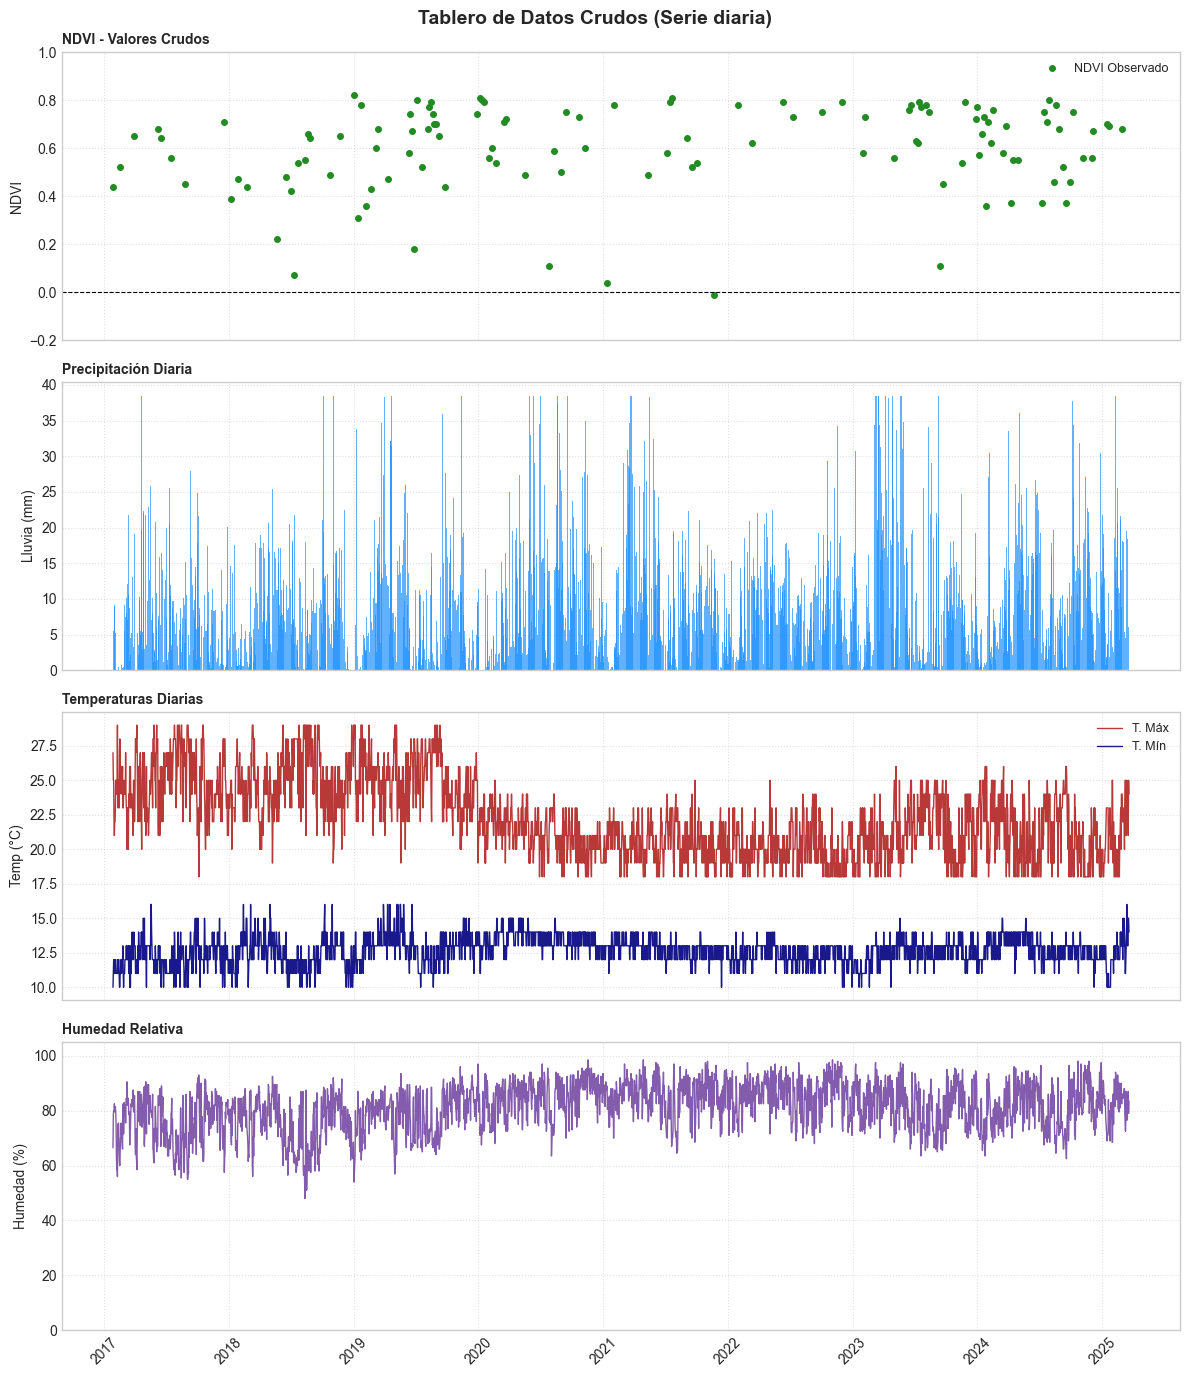

In [93]:
# -------------------------------------------------------------------------
# 1. PREPARACIÓN DE DATOS (Carga tu BD real aquí)
# -------------------------------------------------------------------------

# Asumimos que 'bd_filtrada' ya existe en tu entorno con tus datos reales.
# Si la tienes en un archivo, descomenta la siguiente línea:
# bd_filtrada = pd.read_csv('tu_archivo.csv')  # o pd.read_excel(...)

df_real = pd.DataFrame(bd_filtrada)

# Aseguramos que la columna Fecha sea de tipo datetime
if 'Fecha' in df_real.columns:
    df_real['Fecha'] = pd.to_datetime(df_real['Fecha'])
    df_real = df_real.sort_values('Fecha') # Ordenamos por seguridad

# -------------------------------------------------------------------------
# 2. FUNCIÓN DE GRAFICACIÓN (Datos Crudos - Sin Interpolación)
# -------------------------------------------------------------------------
def plot_agroclimatic_strict_raw(df):
    # Copia para no modificar el original
    df_plot = df.copy()
    
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    
    # --- GRÁFICO 1: NDVI (Puntos Crudos) ---
    ax1 = axes[0]
    # linestyle='None' es CLAVE: evita que matplotlib una los puntos con líneas.
    # Solo muestra el marcador donde existe un dato real.
    ax1.plot(df_plot['Fecha'], df_plot['NDVI'], color='forestgreen', 
             marker='o', linestyle='None', markersize=4, label='NDVI Observado')
    
    # Línea de referencia
    ax1.axhline(0, color='black', linewidth=0.8, linestyle='--')
    
    ax1.set_ylabel('NDVI')
    ax1.set_title('NDVI - Valores Crudos', loc='left', fontweight='bold', fontsize=10)
    ax1.legend(loc='upper right', fontsize=9)
    
    # Ajuste de límites Y (puedes comentarlo si quieres que sea automático)
    ax1.set_ylim(-0.2, 1.0) 
    ax1.grid(True, linestyle=':', alpha=0.6)

    # --- GRÁFICO 2: PRECIPITACIÓN (Barras) ---
    ax2 = axes[1]
    ax2.bar(df_plot['Fecha'], df_plot['Precipitaciones (mm)'], color='dodgerblue', alpha=0.7, width=1.5, label='Lluvia')
    ax2.set_ylabel('Lluvia (mm)')
    ax2.set_title('Precipitación Diaria', loc='left', fontweight='bold', fontsize=10)
    ax2.grid(True, linestyle=':', alpha=0.6)

    # --- GRÁFICO 3: TEMPERATURAS ---
    ax3 = axes[2]
    # Matplotlib por defecto corta la línea si encuentra un NaN (hueco).
    # No "inventará" datos entre huecos a menos que usemos funciones de relleno.
    ax3.plot(df_plot['Fecha'], df_plot['Máx_grado_C'], color='firebrick', linewidth=1, alpha=0.9, label='T. Máx')
    ax3.plot(df_plot['Fecha'], df_plot['Mín_grado_C'], color='navy', linewidth=1, alpha=0.9, label='T. Mín')
    ax3.set_ylabel('Temp (°C)')
    ax3.set_title('Temperaturas Diarias', loc='left', fontweight='bold', fontsize=10)
    ax3.legend(loc='upper right', fontsize=9)
    ax3.grid(True, linestyle=':', alpha=0.6)

    # --- GRÁFICO 4: HUMEDAD ---
    ax4 = axes[3]
    ax4.plot(df_plot['Fecha'], df_plot['Humedad_(%)'], color='rebeccapurple', linewidth=1, alpha=0.8, label='Humedad')
    ax4.set_ylabel('Humedad (%)')
    ax4.set_title('Humedad Relativa', loc='left', fontweight='bold', fontsize=10)
    ax4.set_ylim(0, 105)
    ax4.grid(True, linestyle=':', alpha=0.6)
    
    # --- FORMATO EJE X ---
    ax4.xaxis.set_major_locator(mdates.YearLocator())
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Tablero de Datos Crudos (Serie diaria)', fontsize=14, fontweight='bold')
    
    plt.show()

# -------------------------------------------------------------------------
# 3. EJECUCIÓN
# -------------------------------------------------------------------------
# Solo funcionará si la variable 'bd_filtrada' existe y tiene las columnas correctas
try:
    plot_agroclimatic_strict_raw(df_real)
except NameError:
    print("Error: No se encontró la variable 'bd_filtrada'. Asegúrate de cargar tus datos primero.")
except KeyError as e:
    print(f"Error: A tu base de datos le falta la columna: {e}")